#komentarze

#dane_testowe = torch.randn(1, 4, input_size).to(device)

#dane_testowe.shape
#print(model(dane_testowe).shape)


#torch.Size([1, 2])

#randn(batch_size, seq_len, features)

#batch_size = ile oddzielnych próbek wrzucasz do sieci jednocześnie
#seq_len = ile dni do tyłu patrzymy(60 to 60 dni do tyłu)
#features = ile cech (liczb) opisuje (ile mamy wejsciowych kolumn)
'''
        x.shape = (batch_size, seq_len, input_size)

        lstm_out, hidden = self.lstm(x)

        1)
        lstm_out.shape = (batch_size, seq_len, hidden_size)
        #stany ukryte dla kazdego kroku
        czyli
        lstm_out[b, t] = stan LSTM po kroku t
        to stan LSTM po kroku numer t




        2)
        h_n.shape = (num_layers, batch_size, hidden_size)
        c_n.shape = (num_layers, batch_size, hidden_size)


        h_n → ostatni hidden state
        c_n → ostatni cell state
        tylko OSTATNI krok czasowy
        osobno dla każdej warstwy




        my wybieramy ostatni krok z lstm_out bo ostatni hidden state = podsumowanie sekwencji
        '''


In [304]:
import torch
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset #do koncowego przygotowania danych
import pysam
import yfinance as yf #do danych finansowych

from sklearn.preprocessing import MinMaxScaler #do skalowania

from sklearn.metrics import classification_report #do robienia raportów o uczeniu

import matplotlib.pyplot as plt

In [305]:
data = yf.download(
    "EURPLN=X",
    start="2009-09-09",
    end="2025-09-12",
    interval="1d"
)
#.shift(-1) przesówa dane w GÓRE
data=pd.DataFrame(data)

data["Y"]=np.where(data["Close"]<data["Close"].shift(-1),1,0)
data=data.drop(columns=["Volume"])


data.columns=['Close','High','Low','Open','Y']
#data=data.sort_values(by="Date", ascending=True, inplace=False)
data=data.iloc[:-1,:]
data

#data.Y.value_counts()

/var/folders/ww/wq_mxkmj719cj5jnk01q1qqh0000gn/T/ipykernel_95851/1417105854.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Y
Date,,,,,
2009-09-09,4.12150,4.12230,4.1168,4.11960,1
2009-09-10,4.14050,4.14050,4.1375,4.13860,1
2009-09-11,4.16700,4.19180,4.1375,4.13860,1
2009-09-14,4.18600,4.18730,4.1847,4.18670,0
2009-09-15,4.14530,4.14830,4.1447,4.14520,0
...,...,...,...,...,...
2025-09-04,4.25096,4.25826,4.2435,4.25096,0
2025-09-05,4.24902,4.25408,4.2429,4.24902,1
2025-09-08,4.25133,4.25358,4.2412,4.25133,0


In [306]:
'''
#podział na zbiór treningowy i uczcy

trening_X=data[:int(0.8*len(data))][['Close','High','Low','Open']]
test_X=data[int(0.8*len(data)):][['Close','High','Low','Open']]

trening_y=np.array(data[:int(0.8*len(data))]["Y"])
test_y=np.array(data[int(0.8*len(data)):]["Y"])

#print(trening_X.tail())
#print(test_y.head())

np.unique(trening_y,return_counts=True)'''


split_point = int(0.8 * len(data))

# Trening bez zmian
trening_X = data.iloc[:split_point][['Close', 'High', 'Low', 'Open']]
trening_y = data.iloc[:split_point]["Y"].values

# Test zaczyna się 64 dni PÓŹNIEJ (żeby żadne okno testowe nie zawierało danych z treningu)
test_X = data.iloc[split_point + 64 : ][['Close', 'High', 'Low', 'Open']]
test_y = data.iloc[split_point + 64 : ]["Y"].values



In [307]:
def sekwencje(X,y,seq_len):
    seq_x=[]
    seq_y=[]
    for i in range(len(X)-seq_len):
        seq_x.append(X[i:i+seq_len])
        seq_y.append(y[i+seq_len-1])
    return np.array(seq_x),np.array(seq_y)

In [308]:
#minmax

scaler=MinMaxScaler()
scaler.fit(trening_X)
trening_x=scaler.transform(trening_X)
test_x=scaler.transform(test_X)

trening_x_seq,trening_y_seq=sekwencje(trening_x,trening_y,64)
test_x_seq,test_y_seq=sekwencje(test_x,test_y,64)

#print(trening_x)
#print()
#print(trening_y)
#print()
#print(trening_x_seq)

#przygotowujemy dane do uczenia 

train_data=TensorDataset(torch.Tensor(trening_x_seq),torch.LongTensor(trening_y_seq))
test_data=TensorDataset(torch.Tensor(test_x_seq),torch.LongTensor(test_y_seq))
#dzielimi na batche 

train_loader=DataLoader(train_data, batch_size=64, shuffle=True)
test_loader=DataLoader(test_data, batch_size=64, shuffle=False)

In [309]:

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("GPU dla M1 pro")

GPU dla M1 pro


In [310]:
class waluty(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size=2,dropout_prob=0.4):
        super().__init__()

        self.hidden_size=hidden_size
        self.num_layers= num_layers
       
        #nienawidze zimy
        self.lstm=nn.LSTM(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True, # to tylko zmiena kolejnosc w przyjmowaniudanych ale szczegółów nie znam
                          dropout=dropout_prob if num_layers>1 else 0 )

        self.classifier=nn.Sequential(
            nn.Linear(hidden_size,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(32,output_size))

    def forward(self,x):
        lstm_out, _ =self.lstm(x)
        last_step = lstm_out[:, -1, :]
        out=self.classifier(last_step)

        return out

        
        
        

Epoka 1: Train Loss: 0.7082 | Val Loss: 0.6999
Epoka 11: Train Loss: 0.7024 | Val Loss: 0.6922
Epoka 21: Train Loss: 0.6977 | Val Loss: 0.6913
Epoka 31: Train Loss: 0.6888 | Val Loss: 0.6855
Epoka 41: Train Loss: 0.6856 | Val Loss: 0.6810
Epoka 51: Train Loss: 0.6806 | Val Loss: 0.6818
Epoka 61: Train Loss: 0.6777 | Val Loss: 0.6758
Epoka 71: Train Loss: 0.6724 | Val Loss: 0.6729
Epoka 81: Train Loss: 0.6709 | Val Loss: 0.6712
Epoka 91: Train Loss: 0.6659 | Val Loss: 0.6699
Epoka 101: Train Loss: 0.6610 | Val Loss: 0.6604
Epoka 111: Train Loss: 0.6555 | Val Loss: 0.6554
Epoka 121: Train Loss: 0.6489 | Val Loss: 0.6477
Epoka 131: Train Loss: 0.6419 | Val Loss: 0.6396
Epoka 141: Train Loss: 0.6346 | Val Loss: 0.6358
Epoka 151: Train Loss: 0.6293 | Val Loss: 0.6267
Epoka 161: Train Loss: 0.6202 | Val Loss: 0.6191
Epoka 171: Train Loss: 0.6127 | Val Loss: 0.6206
Epoka 181: Train Loss: 0.6037 | Val Loss: 0.6025
Epoka 191: Train Loss: 0.5930 | Val Loss: 0.5984

--- Raport Wyników ---
       

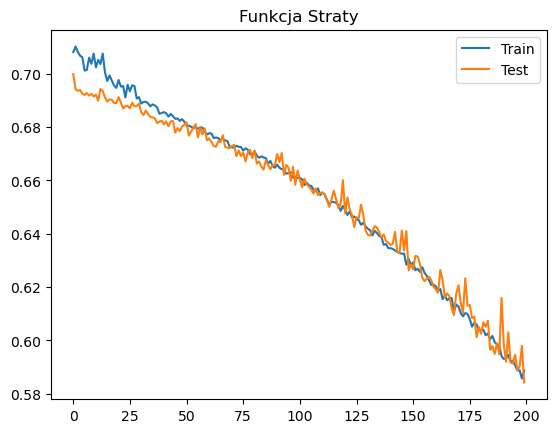

In [311]:
input_size=4
hidden_size=128
num_layers=1
epoch=200

model=waluty(input_size,hidden_size,num_layers).to(device)

criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


train_losses = []
test_losses = []

for i in range(epoch):
    model.train()
    running_loss=0.0


    for inputs,target in train_loader:
        
        inputs,target=inputs.to(device), target.to(device)
        optimizer.zero_grad()
        
        output=model(inputs)

        loss=criterion(output, target)
        loss.backward()


        optimizer.step()
        
        running_loss += loss.item()


        

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)




    

    model.eval()
    val_loss=0.0


    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            #_, predicted = torch.max(outputs, 1)


            probabilities = torch.softmax(outputs, dim=1)
            
            # 2. Wyciągamy prawdopodobieństwo dla klasy "Wzrost" (indeks 1)
            prob_wzrost = probabilities[:, 1]
            
            # 3. Ręczny próg: jeśli P(Wzrost) > 0.45, to uznajemy, że wzrośnie (klasa 1)
            # W przeciwnym razie klasa 0
            prog = 0.5
            predicted = (prob_wzrost > prog).long()




            
            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    test_losses.append(val_loss / len(test_loader))
    if i%10==0:
        print(f"Epoka {i+1}: Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(test_loader):.4f}")





print("\n--- Raport Wyników ---")
print(classification_report(all_labels, all_preds, target_names=['Spadek', 'Wzrost']))

# Wykres
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Funkcja Straty')
plt.legend()
plt.show()